# ML / DL Prototype 

Time Estimate: 25 - 30 Hours / 50 - 60 Hours (depending on if you decide to build both prototypes)
The goal of this step is to find a machine learning or deep learning approach that works for your problem, and then show that the approach you choose is a viable one. Since the application has not been deployed to production yet, we’ll call it a prototype.

For this step, you’ll build your prototype in a Jupyter notebook. Depending on your problem, you’ll be using a more ‘traditional’ machine learning (ML) technique or a deep learning (DL) technique. Your goal is to come up with a working implementation of your prototype in a Jupyter notebook. This prototype could work on a subset of the data but demonstrates that your approach to solving the problem is a viable one based on the following criteria:
- The data has been reasonably split into training, validation, and test sets.
- You have used the correct metric(s) to evaluate the performance of your
algorithm.
- The performance of your algorithm is ‘good enough’ as determined by your mentor.

### Rubric

- The submission shows that the student understands how to design, implement, and justify a suitable machine learning and/or deep learning approach to a problem.
- The submission demonstrates that the student made thoughtful decisions about validating and testing the approach:
    - The data has been reasonably split into training, validation, and test sets
    - The ML/DL algorithm chosen for the approach makes sense in the context of the problem
    - The student has used the correct metric(s) to evaluate the performance of their algorithm
    - The performance of their algorithm is ‘good enough’ to meet the requirements of the business problem

- Well-documented GitHub repository and code. The Jupyter notebooks for the code provide step-by-step documentation that’s easy to follow. 

## ML Prototype

Summary: Light Gradient boosting optimized with SK Optimize

Pipeline
- feature extraction 
    - audio limit    
- oversampling using ADASYN
- feature standardization using Quantile Transformer
- PCA (search components)
- LGBM
    - thorough hyperparameter search with skoptimize

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

Load dataset including mapped audio and computed features.

In [4]:
df = pd.read_pickle('data/features/df.pkl')

In [5]:
extract_limit = df.extract_limit.values[0]
sr = df.sr.values[0]

# cannot use select_dtypes since features stored under *int* index *names*
X = df[(c for c in df.columns.values if isinstance(c, int))]
y = df['emotion_class']

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=0)

print('limit ', extract_limit)
print('sr ', sr)
print('X ', X.shape)
print('y', y.shape)
print('X train ', X_train.shape)
print('y train ', y_train.shape)
print('X test', X_test.shape)
print('y train', y_test.shape)

limit  110250
sr  22050.0
X  (13700, 160)
y (13700,)
X train  (10960, 160)
y train  (10960,)
X test (2740, 160)
y train (2740,)


## Experiment

Cross validate extraction hyperparams using silhouette score.

mfcc 
- n_mfcc in [13, 26] 
- dct_type in [1, 2, 3]

chroma_stft
- n_fft=220 for .01 s and 2205 for .1 s, hop length can be 1/2 or 1/4 the window size
- hop_length
- m_chroma=12
- center=T/F

melspectrogram 
- n_fft=220 for .01 s and 2205 for .1 s, hop length can be 1/2 or 1/4 the window size
- hop_length

In [41]:
import librosa

def extract_mfcc(audio, sr, **kwargs):
    return np.mean(librosa.feature.mfcc(y=audio, sr=sr, **kwargs).T, axis=0)


def extract_chroma(audio, sr, **kwargs):
    stft = np.abs(librosa.stft(audio))
    return np.mean(librosa.feature.chroma_stft(S=stft, sr=sr, **kwargs).T, axis=0)


def extract_melspectrogram(audio, sr, **kwargs):
    return np.mean(librosa.feature.melspectrogram(y=audio, sr=sr, **kwargs).T, axis=0)
     

In [42]:
def run_extract(df, lim, func, **kwargs):
    X = []
    for i, r in df.iterrows():
        audio = r.audio if lim is None else r.audio[:lim]
        X.append(func(audio, r.sr, **kwargs))
    
    return np.array(X)

In [29]:
# test MFCC hyperparams
xs = list(range(10, 30))
scores = list()
for n_mfcc in xs:  
    sample = df.sample(6000)  
    X = run_extract(sample, extract_limit, extract_mfcc, n_mfcc=n_mfcc)
    scores.append(silhouette_score(X, sample['emotion_class']))

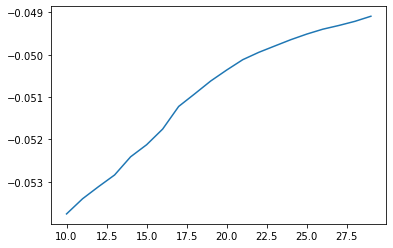

In [43]:
plt.plot(xs, scores);

In [ ]:
# test chroma hyperparams
xs = list(range(8, 17))
scores = list()
for n_chroma in xs:  
    sample = df.sample(6000)  
    X = run_extract(sample, extract_limit, extract_chroma, n_chroma=n_chroma)
    scores.append(silhouette_score(X, sample['emotion_class']))

In [16]:
plt.plot(xs, scores);

NameError: name 'xs' is not defined

## ML Prototype

Pipeline
- oversampling using ADASYN
- feature standardization using Quantile Transformer
- PCA (search components)
- LGBM
    - thorough hyperparameter search with skoptimize



In [ ]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import ADASYN
import lightgbm as lgb
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV


pipe = Pipeline([
    ('oversample', ADASYN(random_state=0, n_jobs=-1)), 
    ('standardize', QuantileTransformer(output_distribution='normal', random_state=0)),
    ('decomposition', PCA(random_state=0)),
    ('estimator', lgb.LGBMClassifier(objective='multiclass', class_weight='balanced')),
])
params = {
    'decomposition__n_components': list(range(10, 101)) 
}
search = GridSearchCV(pipe, params, scoring='f1_weighted', cv=5, n_jobs=-1) 

search.fit(X_train, y_train)
search.best_params_

In [ ]:
import seaborn as sns

def grid_search_plot(search, x, hue=None, col=None):
    result_df = pd.DataFrame.from_dict(search.cv_results_, orient='columns')
    grid = sns.relplot(data=result_df,
                kind='line',
                x='param_' + x,
                y='mean_test_score',
                hue='param_' + hue if hue else None, 
                col='param_' + col if col else None)
    grid.fig.set_size_inches(15, 10)

In [ ]:
grid_search_plot(search, 'decomposition__n_components');

In [57]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import TimerCallback, DeadlineStopper

# BayesSearchCV

## DL Prototype

Summary: 
1. CNN on melspectrogram followed by Linear Classifier
2. Create sequence of features and use LSTM